In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy



from funcs.model import full_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

#-----------------------------------
import numpy as np
import pandas as pd

from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.multiperiod import remove_sinusoidal
from funcs.helper import fetch_lightcurve

import time

# Different flare/active region configurations have different numbers of parameters
log_probs = {"log_probability": 6, # one flare, one active region
             "log_probability_2flares": 9, # two flares, one active region
             "log_probability_2flares2ars": 10 # two flares, two active regions
            }



# Create a time stamp for this run
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())




In [23]:
tstamp

'24_07_2020_13_09'

In [27]:
# Read in target parameters
# ALL TARGETS MUST BE DEFINED IN THIS TABLE AND HAVE LIGHT CURVE
# OTHERWISE NOTHING WILL WORK
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

# Choose target from table
target_N = 1
target = lcs.iloc[target_N]

# Pick up inclination and uncertainty
i_mu, i_sigma = target.i_mu, target.i_sigma

target

ID                           237880881
QCS                                  1
typ                                slc
cadence_min                          2
mission                           tess
prefix                             TIC
origin                         generic
h_mission                         TESS
SpT                                 M5
view_start                        1331
view_stop                       1333.5
view_min                           560
view_max                           700
BJDoff                         2457000
tstart                          1331.7
ampl_min                           NaN
ampl_max                           NaN
GRP                                NaN
plxmas                             NaN
eplxmas                            NaN
RA                              19.528
Dec                           -62.9831
J                                11.53
R                                  NaN
Gaia_G                         14.9796
vsini_kms                

In [28]:

# Get the light curve of the target
# from a pre-defined path
flck = fetch_lightcurve(target)

# We are dealing with ultrafast rotators witha simple sinusoidal signal
t, sflux, model, period = remove_sinusoidal(target, plot=False, save=False)

# define flare light curve so that you can use find_iterative_median later
flcd = FlareLightCurve(time=t, 
                       detrended_flux=sflux, 
                       detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))


# Choose the light curve range to use for the model fit
choice = (t > target.view_start +.6) & (t < target.view_stop-.25) 
t = t[choice]
flux = sflux[choice]

# Define the flux error
flux_err = np.nanmean(flcd.detrended_flux_err)

# Find the median flux in the chosen light curve range
# by clipping outliers iteratively
flcd = flcd[choice]
median = np.nanmean(find_iterative_median(flcd).it_med)


# Convert time array to rotation phase array
# using the rotation period of the star
phi = (t - t[0]) / target.Prot_d * 2 * np.pi

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


{'time': array([1325.29815173, 1325.29954065, 1325.30092957, ..., 1353.17629563,
       1353.17768452, 1353.17907341]), 'flux': array([624.7549 , 617.42035, 616.01654, ..., 607.1135 , 602.7352 ,
       605.9293 ], dtype=float32), 'flux_err': array([5.5513787, 5.5398965, 5.5334425, ..., 5.453243 , 5.445567 ,
       5.455252 ], dtype=float32), '_flux_unit': Unit("electron / s"), 'time_format': 'btjd', 'time_scale': 'tdb', 'targetid': 237880881, 'label': 'TIC 237880881', 'meta': {}, 'centroid_col': array([721.42135831, 721.40457996, 721.4067695 , ..., 721.37027388,
       721.3585656 , 721.37325521]), 'centroid_row': array([1499.2800729 , 1499.2641131 , 1499.25419659, ..., 1499.30493254,
       1499.28344546, 1499.30525456]), 'quality': array([0, 0, 0, ..., 0, 0, 0], dtype=int32), 'cadenceno': array([70445, 70446, 70447, ..., 90517, 90518, 90519], dtype=int32), 'quality_bitmask': 'default', 'mission': 'TESS', 'sector': 1, 'camera': 3, 'ccd': 1, 'ra': 19.527933, 'dec': -62.983093}
{'time':

In [29]:
median

618.8385055837792

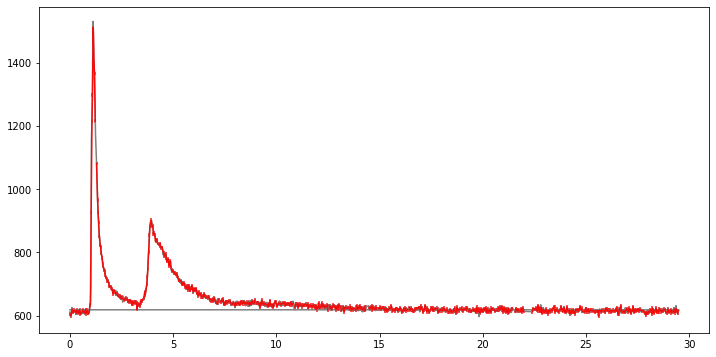

In [31]:
cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
plt.figure(figsize=(12,6))
plt.plot(cf.phi, cf.flux,color="grey")
plt.errorbar(cff.phi, cff.flux, yerr=cff.flux_err, color="r", alpha=.9)
plt.plot(cf.phi, [median]*len(cf.phi),color="grey")
#plt.xlim(25,30)

In [32]:
cff

,phi,flux,t,flux_err,median_
phi,,,,,
"(-0.0295, 0.0328]",0.012423,605.205713,1331.601763,5.800927,618.838506
"(0.0328, 0.0655]",0.049690,600.168069,1331.603847,5.800927,618.838506
"(0.0655, 0.0983]",0.074535,606.877607,1331.605235,5.800927,618.838506
"(0.0983, 0.131]",0.111803,619.925253,1331.607319,5.800927,618.838506
"(0.131, 0.164]",0.149070,609.864007,1331.609402,5.800927,618.838506
...,...,...,...,...,...
"(29.327, 29.36]",29.342002,620.569379,1333.241380,5.800927,618.838506
"(29.36, 29.393]",29.379269,622.765588,1333.243463,5.800927,618.838506
"(29.393, 29.426]",29.416536,613.519117,1333.245546,5.800927,618.838506


In [33]:
cff.dropna(how="any").to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
len(phi)

1125

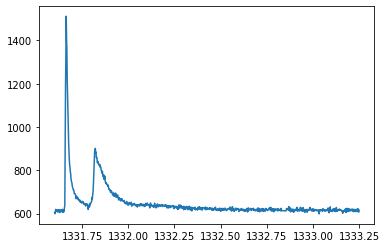

In [34]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median
plt.plot(lc.t, lc.flux)

In [35]:
tstamp

'24_07_2020_13_09'

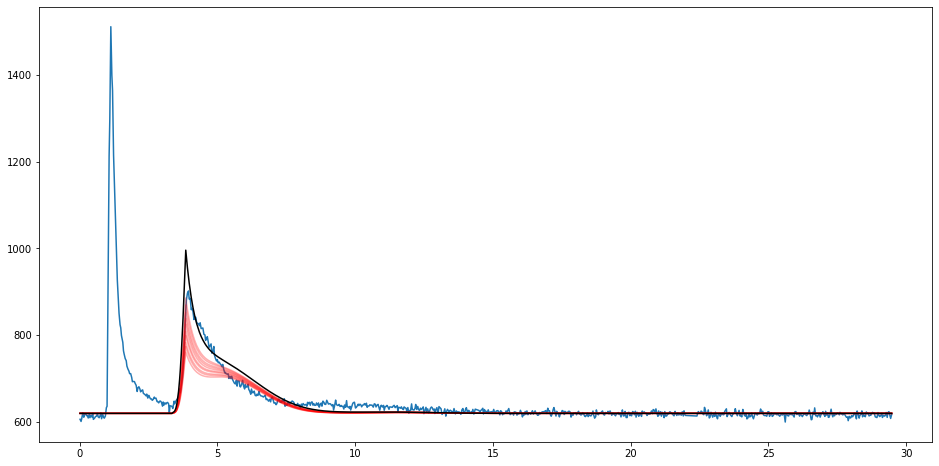

In [103]:

phi_a =3.85
theta_a = .587
a = 2.2
fwhm =  .95
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 0.00314
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
#theta_a, i_mu, phi_a, radius



plt.figure(figsize=(16,8))
plt.plot(phi,flux)
for i in np.linspace(np.pi*.1,np.pi*.15,10):
    plt.plot(phi, full_model(phi_a, i, a, fwhm, i_mu, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
# plt.xlim(1331,1333.25)

In [104]:

log_prob = "log_probability_2flares2ars"
nparam = log_probs[log_prob]

with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID}b,{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)